#Billedeklassificering med Neurale Netværk

I denne notebook arbejdes der med implementering og træning af et simpelt neuralt netværk. Når I er færdige så skulle i gerne have fået indsigt i hvordan denne type af modeller, hvor linære transformationer arrangeret i lag med mellemliggende non-linære "activation functions" kan bruges i kontruktion af mere komplekse klassificeringsmodeller, og hvilke hyperparametere der kan tunes under træning af disse. Herunder hvordan loss/cost funktionen udregnes og hvordan gradienten af loss i henhold til modellens parameter bruges til at optimere modellen vha. af gradient decent.



#Datasættet
Ligesom for kNN og liniære modeller, så anvendes der i denne notebook data fra "BloodMNIST" datasættet som kommer fra [MedMNIST databasen](https://medmnist.com/)

#Beskrivelse fra oprindelig kilde:
The BloodMNIST is based on a dataset of individual normal cells, captured from individuals without infection, hematologic or oncologic disease and free of any pharmacologic treatment at the moment of blood collection. It contains a total of 17,092 images and is organized into 8 classes. We split the source dataset with a ratio of 7:1:2 into training, validation and test set.

Billederne er tilgængelige i forskellige opløsninger 28x28, 64x64, 128x128,og 224x224 med 3 kanaler (RGB). I denne notebook arbejder vi med billeder i opløsning 28x28x3. De 8 forskellige klasser er:

['basophil', 'eosinophil', 'erythroblast', 'immature granulocytes', 'lymphocyte', 'monocyte', 'neutrophil', 'platelet']


Angivet kategorisk med værdierne:

[0, 1, 2, 3, 4, 5, 6, 7]

Nedenfor downloades og importeres datasættet og opdeles i separate trænings- og valideringssæt (tuning) og nogle eksempler illustreres. (samme procedure som for liniære modeller)

In [2]:
%pip install medmnist
import medmnist

from medmnist import BloodMNIST
trainDataset = BloodMNIST(split="train", download=True,size=28)
valDataset = BloodMNIST(split="val", download=True,size=28)
testDataset = BloodMNIST(split="test", download=True,size=28)

Note: you may need to restart the kernel to use updated packages.
Using downloaded and verified file: C:\Users\Simon\.medmnist\bloodmnist.npz
Using downloaded and verified file: C:\Users\Simon\.medmnist\bloodmnist.npz
Using downloaded and verified file: C:\Users\Simon\.medmnist\bloodmnist.npz


Træningsdata:
Billeder: (11959, 28, 28, 3), Labels: (11959, 1)
Valideringsdata:
Billeder: (1712, 28, 28, 3), Labels: (1712, 1)
Testdata:
Billeder: (3421, 28, 28, 3), Labels: (3421, 1)


plot nogle eksempler:
klasse: 0, klassenavn: basophil. Antal træning samples: 852
klasse: 1, klassenavn: eosinophil. Antal træning samples: 2181
klasse: 2, klassenavn: erythroblast. Antal træning samples: 1085
klasse: 3, klassenavn: immature granulocytes(myelocytes, metamyelocytes and promyelocytes). Antal træning samples: 2026
klasse: 4, klassenavn: lymphocyte. Antal træning samples: 849
klasse: 5, klassenavn: monocyte. Antal træning samples: 993
klasse: 6, klassenavn: neutrophil. Antal træning samples: 2330
klasse: 7, klassenavn: platelet. Antal træning samples: 1643


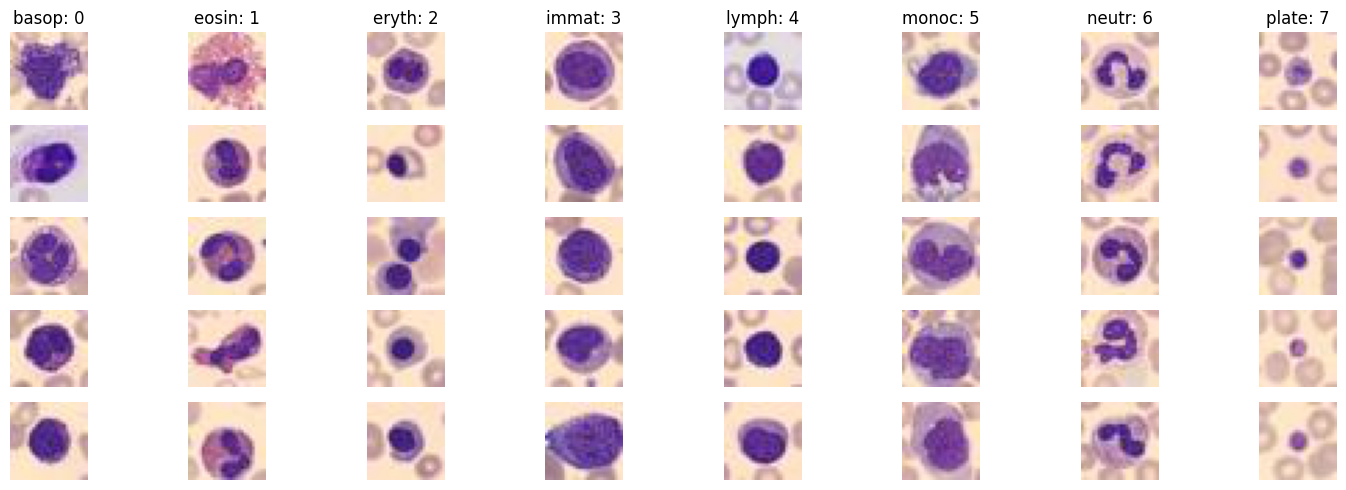

In [3]:
trainImages,trainLabels,trainInfo = trainDataset.__dict__['imgs'],trainDataset.__dict__['labels'],trainDataset.__dict__['info']['label']


print('Træningsdata:')
print(f'Billeder: {trainImages.shape}, Labels: {trainLabels.shape}')


valImages,valLabels = valDataset.__dict__['imgs'],valDataset.__dict__['labels']
print('Valideringsdata:')
print(f'Billeder: {valImages.shape}, Labels: {valLabels.shape}')

testImages,testLabels = testDataset.__dict__['imgs'],testDataset.__dict__['labels']
print('Testdata:')
print(f'Billeder: {testImages.shape}, Labels: {testLabels.shape}')

import matplotlib.pyplot as plt
import random

print('\n')
print('plot nogle eksempler:')

random.seed(42)
fig, axes = plt.subplots(5, len(trainInfo), figsize=(15, 5))

for class_,name in trainInfo.items():
    print(f'klasse: {class_}, klassenavn: {name}. Antal træning samples: {len(trainLabels[trainLabels==int(class_)])}')
    # Get indices of all images belonging to class i
    class_indices = [idx for idx, label in enumerate(trainLabels) if int(class_) == label]
    # Randomly select 5 indices
    selected_indices = random.sample(class_indices, 5)
    for j, idx in enumerate(selected_indices):
        image, label = trainImages[idx],trainLabels[idx]
        axes[j, int(class_)].imshow(image, cmap='gray')
        axes[j, int(class_)].axis('off')
        if j == 0:
            axes[j, int(class_)].set_title(f'{name[:5]}: {class_}')

plt.tight_layout()
plt.show()

In [4]:
import numpy as np

#set random seed for reproducibility
np.random.seed(0)

#Shuffle the data
randomize = np.arange(trainImages.shape[0])
np.random.shuffle(randomize)

X_train = trainImages[randomize]
y_train = trainLabels[randomize].flatten()

randomizeVal = np.arange(valImages.shape[0])
X_val = valImages[randomizeVal]
y_val = valLabels[randomizeVal].flatten()


# Subsample the data for more efficient code execution in this exercise
num_training = 5000
mask = list(range(num_training))

X_train = X_train[mask]
y_train = y_train[mask]

print('first 10 examples in train: ',y_train[:10])

num_val = 500
mask = list(range(num_val))
X_val = X_val[mask]
y_val = y_val[mask]

print('first 10 examples in val: ',y_val[:10])

# Reshape the image data into rows for effecient distance calculation
#(vi tager billedet med dimensioner 28x28x3 og strækker det ud til en vektor med længden 28*28*3 = 2352)
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
print(f'New train shape: {X_train.shape}')
print(f'New val shape: {X_val.shape}')


first 10 examples in train:  [1 0 2 7 7 4 3 0 4 7]
first 10 examples in val:  [4 0 7 6 1 6 1 7 6 5]
New train shape: (5000, 2352)
New val shape: (500, 2352)


[230.0064 199.1086 185.6402 230.0196 199.0904 185.7078 229.8808 199.2164
 185.9048 230.2784]


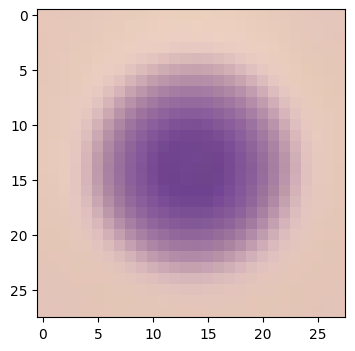

-194.6206 173.8098
(5000, 2352) (500, 2352)


In [5]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((28,28,3)).astype('uint8')) # visualize the mean image
plt.show()

# second: subtract the mean image from train and test data
X_train = X_train.astype(np.float32)-mean_image
X_val = X_val.astype(np.float32)-mean_image

print(X_train.min(),X_train.max())

print(X_train.shape, X_val.shape)

## Standadizing data
We standardize the data, i.e. divide by 255 to get it on a scale from [-1,1]. This may help to avoid exploding gradients since the current values of the input data are quite large.



In [6]:
X_train /= 255.
X_val /= 255.

# Implementation of simple, fully connected neural network
One way could be to construct the model using a modular approach. I.e. define the different building blocks of the model seperately such that they can be put together arbitrarily at a later point. E.g. for constructing networks with more layers.

So for instance, each layer in a neural network performs two operations. A forward operation/"pass", where an output is computed based the input to the layer and the layers internal parameters. The output is then passed to the subsequent layer along with a cache object storing data needed for the backward pass.

In the backwards operation, the layer recieves the backwards/upstream gradient with information on how the output affected the loss computation at the end of the network And using the cache object the gradient with respect the the layers inputs (dx,dW) are calculated and the gradients dW can then be used to optimize the parameters.

Below, we have and implementation of the simple neural network.

In [7]:
import numpy as np

class FullyConnectedNN:
    def __init__(self, layers, reg_strength=0.01, loss='softmax', seed=42):
        """
        layers: List where each element represents the number of nodes in that layer.
        reg_strength: L2 regularization strength
        loss: 'softmax' or 'hinge'
        """
        np.random.seed(seed)
        self.layers = layers
        self.reg_strength = reg_strength
        self.loss_type = loss
        self.params = self._initialize_weights(layers)
        self.learning_rate = 1
        self.optimizer = 'sgd'
        self.epochs = 0
        self.batch_size = 0
        self.history = []


    def _initialize_weights(self, layers):
        """
        Initialize weights and biases for each layer
        """
        params = {}
        for i in range(1, len(layers)):
            params['W' + str(i)] = np.random.randn(layers[i-1], layers[i]) * 0.01
            params['b' + str(i)] = np.zeros((1, layers[i]))
        return params

    def relu(self, Z):
        return np.maximum(0, Z)

    def relu_derivative(self, Z):
        return Z > 0

    def softmax(self, Z):
        exp_Z = np.exp(Z - np.max(Z, axis=1, keepdims=True))
        return exp_Z / np.sum(exp_Z, axis=1, keepdims=True)

    def softmax_loss(self, A, y):
        m = y.shape[0]
        p = self.softmax(A)
        log_likelihood = -np.log(p[range(m), y])
        loss = np.sum(log_likelihood) / m
        return loss

    def hinge_loss(self, A, y):
        m = y.shape[0]
        correct_class_scores = A[range(m), y].reshape(-1, 1)
        margins = np.maximum(0, A - correct_class_scores + 1)
        margins[range(m), y] = 0
        loss = np.sum(margins) / m
        return loss

    def compute_loss(self, A, y):
        if self.loss_type == 'softmax':
            return self.softmax_loss(A, y) + self._l2_regularization()
        elif self.loss_type == 'hinge':
            return self.hinge_loss(A, y) + self._l2_regularization()

    def _l2_regularization(self):
        reg_loss = 0
        for i in range(1, len(self.layers)):
            reg_loss += np.sum(np.square(self.params['W' + str(i)]))
        return self.reg_strength * reg_loss / 2

    def forward(self, X):
        cache = {'A0': X}
        A = X
        for i in range(1, len(self.layers)):
            W, b = self.params['W' + str(i)], self.params['b' + str(i)]
            Z = np.dot(A, W) + b
            if i != len(self.layers) - 1:
                A = self.relu(Z)
            else:
                A = Z  # No activation in the output layer (raw scores for loss)
            cache['Z' + str(i)] = Z
            cache['A' + str(i)] = A
        return A, cache

    def backward(self, cache, y):
        grads = {}
        m = y.shape[0]
        A_last = cache['A' + str(len(self.layers) - 1)]
        if self.loss_type == 'softmax':
            dA = self.softmax(A_last)
            dA[range(m), y] -= 1
            dA /= m
        elif self.loss_type == 'hinge':
            margins = (A_last - A_last[range(m), y].reshape(-1, 1) + 1) > 0
            margins[range(m), y] = 0
            dA = np.where(margins, 1, 0)
            dA /= m

        for i in reversed(range(1, len(self.layers))):
            dZ = dA
            A_prev = cache['A' + str(i - 1)]
            grads['W' + str(i)] = np.dot(A_prev.T, dZ) + self.reg_strength * self.params['W' + str(i)]
            grads['b' + str(i)] = np.sum(dZ, axis=0, keepdims=True)
            if i > 1:
                dA = np.dot(dZ, self.params['W' + str(i)].T) * self.relu_derivative(cache['Z' + str(i - 1)])

        return grads

    def update_params(self, grads, learning_rate, v=None, beta1=0.9, beta2=0.999, t=1, optimizer='sgd'):
        """
        Updates parameters with chosen optimization method.
        If optimizer is 'momentum' or 'adam', it requires v for velocity and also t for time step in adam.
        """
        for i in range(1, len(self.layers)):
            if optimizer == 'sgd':
                self.params['W' + str(i)] -= learning_rate * grads['W' + str(i)]
                self.params['b' + str(i)] -= learning_rate * grads['b' + str(i)]
            elif optimizer == 'momentum':
                v['dW' + str(i)] = beta1 * v['dW' + str(i)] + (1 - beta1) * grads['W' + str(i)]
                v['db' + str(i)] = beta1 * v['db' + str(i)] + (1 - beta1) * grads['b' + str(i)]
                self.params['W' + str(i)] -= learning_rate * v['dW' + str(i)]
                self.params['b' + str(i)] -= learning_rate * v['db' + str(i)]
            elif optimizer == 'adam':
                v['mW' + str(i)] = beta1 * v['mW' + str(i)] + (1 - beta1) * grads['W' + str(i)]
                v['vW' + str(i)] = beta2 * v['vW' + str(i)] + (1 - beta2) * np.square(grads['W' + str(i)])
                mW_hat = v['mW' + str(i)] / (1 - beta1**t)
                vW_hat = v['vW' + str(i)] / (1 - beta2**t)
                self.params['W' + str(i)] -= learning_rate * mW_hat / (np.sqrt(vW_hat) + 1e-8)

    def fit(self, X, y, epochs=100, batch_size=64, learning_rate=0.01, optimizer='sgd'):
        """
        Trains the model using the chosen optimizer.
        """
        self.learning_rate = learning_rate
        self.optimizer = optimizer
        self.epochs = epochs
        self.batch_size = batch_size

        v = None
        if optimizer in ['momentum', 'adam']:
            v = {}
            for i in range(1, len(self.layers)):
                v['dW' + str(i)] = np.zeros_like(self.params['W' + str(i)])
                v['db' + str(i)] = np.zeros_like(self.params['b' + str(i)])
                if optimizer == 'adam':
                    v['mW' + str(i)] = np.zeros_like(self.params['W' + str(i)])
                    v['vW' + str(i)] = np.zeros_like(self.params['W' + str(i)])

        for epoch in range(epochs):
            permutation = np.random.permutation(X.shape[0])
            X_shuffled = X[permutation]
            y_shuffled = y[permutation]

            for i in range(0, X.shape[0], batch_size):
                X_batch = X_shuffled[i:i + batch_size]
                y_batch = y_shuffled[i:i + batch_size]

                A_last, cache = self.forward(X_batch)
                loss = self.compute_loss(A_last, y_batch)
                self.history.append(loss)
                grads = self.backward(cache, y_batch)
                self.update_params(grads, learning_rate, v=v, optimizer=optimizer)

            if epoch % 10 == 0:
                print(f'Epoch {epoch}, Loss: {loss}')

    def predict(self, X):
        A_last, _ = self.forward(X)
        if self.loss_type == 'softmax':
            return np.argmax(A_last, axis=1)
        elif self.loss_type == 'hinge':
            return np.argmax(A_last, axis=1)
        
    def print(self):
        print(f'Layers: {self.layers}, reg_strength: {self.reg_strength}, learning_rate: {self.learning_rate}, optimizer: {self.optimizer}, epochs: {self.epochs}, batch_size: {self.batch_size}')



In [10]:
# Example usage:
# To-lags neuralt netværk med input lag med antal neuroner svarende til input
# størrelsen, ét "hidden" lag med 200 neuroner, og et output lag
# med antal neuroner = antallet af klasser i datasættet.

nn = FullyConnectedNN(layers=[X_train.shape[1], 500, 8], loss='softmax')

# Train the neural network on the subsampled training data for 200 epochs
# using stochastic gradient decent
nn.fit(X_train, y_train,learning_rate=0.01, epochs=200,optimizer='sgd')

Epoch 0, Loss: 2.5617037352449143


KeyboardInterrupt: 

In [8]:
#classify training data and val data using the trained model
preds = nn.predict(X_train)

print(f'Training accuracy={np.mean(preds==y_train)}')


val_preds = nn.predict(X_val)

print(f'Validation accuracy={np.mean(val_preds==y_val)}')

Training accuracy=0.8648
Validation accuracy=0.838


# Optimize the model
Similar to assignment1-1 and assignment1-2 you should now optimize the model. In this notebook we have more hyperparameteres compared to earlier. We can tune the number of layers in the network, number of nodes/neurons in each layer, learning rate, regularization strength, optimizer, loss function and possibly batch size. You should now write you own optimization code. Train the model on the training set and tune hyperparameters on the validation set to find the optimal configuration which maximizes validation accuracy/minimizes validation loss. Record loss/accuracy history on the training and validation data for later visualization.

Once the model has been optimized, test performance on the test set.

Epoch 0, Loss: 7.984147908767882
Epoch 0, Loss: 2.781495826504348
Epoch 0, Loss: 7.105863526391904
Epoch 0, Loss: 2.669619014548944
Epoch 0, Loss: 7.892140274497859
Epoch 0, Loss: 1.865572235981853
Epoch 0, Loss: 2.0374997518799534
Epoch 0, Loss: 2.6241338590939973
Epoch 0, Loss: 2.010460950266978
Epoch 0, Loss: 2.6661167242735053
Epoch 0, Loss: 2.127125446576246
Epoch 0, Loss: 2.1378415072497354
Epoch 0, Loss: 2.0814609140924043
Epoch 0, Loss: 1.31641320998081
Epoch 0, Loss: 2.0739460111006465
Epoch 0, Loss: 1.4603777760850452
Epoch 0, Loss: 2.426629429823928
Epoch 0, Loss: 3.4120349034282276
Epoch 0, Loss: 2.149334619443338
Epoch 0, Loss: 2.795473728082564
Epoch 0, Loss: 9.129324614767611
Epoch 0, Loss: 9.227951972937678
Epoch 0, Loss: 2.7920876285653744
Epoch 0, Loss: 2.0869882214248956
Epoch 0, Loss: 2.0571909276012184
Epoch 0, Loss: 8.208568823835765
Epoch 0, Loss: 1.7688030399050962
Epoch 0, Loss: 2.1521500543277265
Epoch 0, Loss: 2.75524514634341
Epoch 0, Loss: 2.083638122561545

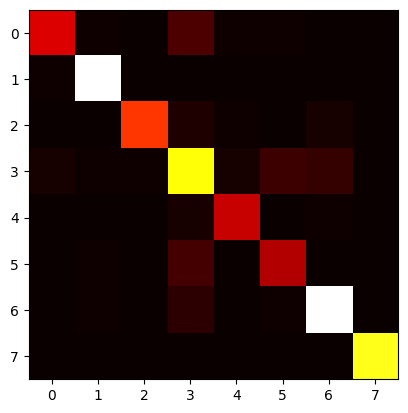

4
Layers: [2352, 500, 8], reg_strength: 0.1, learning_rate: 0.1, optimizer: sgd, epochs: 100, batch_size: 64
Layers: [2352, 500, 8], reg_strength: 0.1, learning_rate: 0.01, optimizer: sgd, epochs: 100, batch_size: 64
Layers: [2352, 500, 8], reg_strength: 0.1, learning_rate: 0.001, optimizer: sgd, epochs: 100, batch_size: 64
Layers: [2352, 500, 8], reg_strength: 0.1, learning_rate: 0.0001, optimizer: sgd, epochs: 100, batch_size: 64
Layers: [2352, 500, 8], reg_strength: 0.01, learning_rate: 0.1, optimizer: sgd, epochs: 100, batch_size: 64
Layers: [2352, 500, 8], reg_strength: 0.01, learning_rate: 0.01, optimizer: sgd, epochs: 100, batch_size: 64
Layers: [2352, 500, 8], reg_strength: 0.01, learning_rate: 0.001, optimizer: sgd, epochs: 100, batch_size: 64
Layers: [2352, 500, 8], reg_strength: 0.01, learning_rate: 0.0001, optimizer: sgd, epochs: 100, batch_size: 64
Layers: [2352, 500, 8], reg_strength: 0.001, learning_rate: 0.1, optimizer: sgd, epochs: 100, batch_size: 64
Layers: [2352, 50

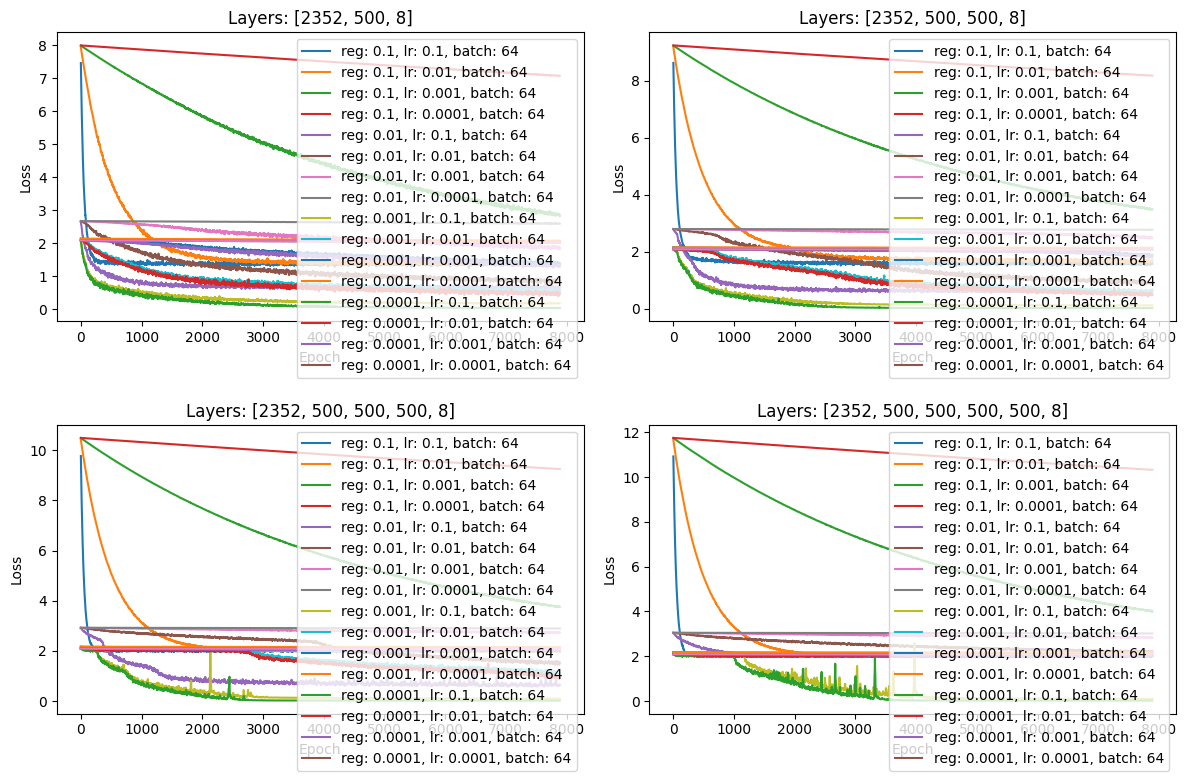

In [8]:
########################################################################
######### your optimization code goes here #############################
########################################################################
# n this notebook we have more hyperparameteres compared to earlier. We can tune the number of layers in the network, number of nodes/neurons in each layer, learning rate, regularization strength, optimizer, loss function and possibly batch size. You should now write you own optimization code. Train the model on the training set and tune hyperparameters on the validation set to find the optimal configuration which maximizes validation accuracy/minimizes validation loss. Record loss/accuracy history on the training and validation data for later visualization.
# Once the model has been optimized, test performance on the test set.

def hyperparameter_tuning():
    best_acc = 0
    # define hyperparameters to tune
    learning_rates = [1e-1, 1e-2, 1e-3, 1e-4]
    reg_strengths = [1e-1, 1e-2, 1e-3]
    batch_sizes = [64]
    layers = [[X_train.shape[1], 500, 8]]
    optimizers = ['sgd', 'momentum', 'adam']
    losses = ['softmax', 'hinge']
    epochs_list = [50]

    # combine hyperparameters

    for lay in layers:
        for lr in learning_rates:
            for rg in reg_strengths:
                nn = FullyConnectedNN(layers=lay, reg_strength=rg , loss='softmax')
                nn.fit(X_train, y_train, learning_rate=lr, epochs=10, optimizer='sgd')
                accuracy = np.mean(nn.predict(X_val) == y_val)
                print(f'Validation accuracy: {accuracy} with layers={lay}, lr={lr}')
                if accuracy > best_acc:
                    best_acc = accuracy
                    best_params = (lay, lr, rg)
    
    print(f'Best validation accuracy: {best_acc} with params: {best_params}')
    
#hyperparameter_tuning()

def multi_threaded_hyperparameter_tuning():

    layers = [[X_train.shape[1], 500, 8],[X_train.shape[1], 500,500, 8], [X_train.shape[1], 500, 500, 500, 8], [X_train.shape[1], 500, 500, 500, 500, 8]]
    learning_rates = [1e-1, 1e-2, 1e-3, 1e-4]
    reg_strengths = [1e-1, 1e-2, 1e-3, 1e-4]
    batch_sizes = [64]

    models = []

    import concurrent.futures
    

    pool = concurrent.futures.ThreadPoolExecutor(max_workers=64)
    futures = []

    # create all possible models
    for layer in layers:
        for reg in reg_strengths:
            for lr in learning_rates:
                for batch in batch_sizes:
                    nn = FullyConnectedNN(layers=layer, reg_strength=reg, loss='softmax')
                    models.append(nn)
                    futures.append(pool.submit(nn.fit, X_train, y_train, learning_rate=lr, epochs=100, batch_size=batch, optimizer='sgd'))

    concurrent.futures.wait(futures)

    # evaluate models on validation set
    best_acc = 0
    best_model = None
    # instantiate dictionary to store loss history for each model with same layers
    histories = {tuple(layer): [] for layer in layers}
    print(f'Models: {len(models)}')
    for model in models:
        # add history to dictionary for later visualization
        histories[tuple(model.layers)].append(model)
        accuracy = np.mean(model.predict(X_val) == y_val)
        print(f'Validation accuracy: {accuracy}')
        if accuracy > best_acc:
            best_acc = accuracy
            best_model = model
    
    print(f'Best validation accuracy: {best_acc}')
    best_model.print()

    # confusion matrix without import
    cm = np.zeros((8, 8))
    preds = best_model.predict(X_val)
    for i in range(len(y_val)):
        cm[y_val[i], preds[i]] += 1
    print(preds[:10])
    print(y_val[:10])
    
    # visualize confusion matrix
    import matplotlib.pyplot as plt
    plt.imshow(cm, cmap='hot', interpolation='nearest')
    plt.show()

    # visualize loss history as a grid
    n_plots = len(layers)
    print(n_plots)


    # import math

    # cols = math.ceil(math.sqrt(n_plots))
    # rows = math.ceil(n_plots / cols)


    # axes = axes.ravel()

    # plot all models with samee layer
    for i, layer in enumerate(layers):
        
        plt.plot(history)
        plt.title(f'Layers: {layer}')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        

        for model in histories[tuple(layer)]:
            model.print()
            history = np.convolve(model.history, np.ones(10) / 10, mode='valid')
            plt.plot(history, label=f'reg: {model.reg_strength}, lr: {model.learning_rate}, batch: {model.batch_size}')

        plt.legend()
        plt.show()


    # for i, model in enumerate(models):
    #     ax = axes[i]

    #     for reg, loss in histories[model.learning_rate]:
    #         history = np.convolve(loss, np.ones(10) / 10, mode='valid')
    #         ax.plot(history, label=f'Reg: {model.reg_strength} ')
    #         ax.legend()
    #         ax.title.set_text(f'LR: {model.learning_rate}, Layers: {model.layers}')

    #     ax.plot(history)
    #     #ax.set_title(f'Layers: {model.layers}, reg: {model.reg_strength}, lr: {model.learning_rate}, batch: {model.batch_size}')
    #     ax.set_xlabel('Epoch')
    #     ax.set_ylabel('Loss')

    # for i in range(n_plots, len(axes)):
    #     axes[i].axis('off')


    plt.tight_layout()
    plt.show()





multi_threaded_hyperparameter_tuning()
    

#Visualize results

In [ ]:
########################################################################
######### visualize hyperparameter tuning history/results ##############
########################################################################

#Evaluate performance

In [ ]:
#######################################################################
######## evaluate on the test data. Consider including    #############
######## relevant metrics such as confusin matrices etc.  #############
#######################################################################

#Assignment report
In the assignment report you should report the results the same way as for assignment1-1 and assignment1-2. I.e. outcome of the hyperparamter search and test set results and metrics.

Since the implementation of the network class has been written. You should make sure to fully understand it and explain relevant implementation details (with code snippets) in the report.

#Visualize learned weights
Like in assignment1-2 we can visualize the learned weights/parameters of the model. If the model has been well optimized you should see some patterns resembling the input data.

In [ ]:
from math import ceil, sqrt
def visualize_grid(Xs, ubound=255.0, padding=1):
    """
    Reshape a 4D tensor of image data to a grid for easy visualization.

    Inputs:
    - Xs: Data of shape (N, H, W, C)
    - ubound: Output grid will have values scaled to the range [0, ubound]
    - padding: The number of blank pixels between elements of the grid
    """
    (N, H, W, C) = Xs.shape
    grid_size = int(ceil(sqrt(N)))
    grid_height = H * grid_size + padding * (grid_size - 1)
    grid_width = W * grid_size + padding * (grid_size - 1)
    grid = np.zeros((grid_height, grid_width, C))
    next_idx = 0
    y0, y1 = 0, H
    for y in range(grid_size):
        x0, x1 = 0, W
        for x in range(grid_size):
            if next_idx < N:
                img = Xs[next_idx]
                low, high = np.min(img), np.max(img)
                grid[y0:y1, x0:x1] = ubound * (img - low) / (high - low)
                # grid[y0:y1, x0:x1] = Xs[next_idx]
                next_idx += 1
            x0 += W + padding
            x1 += W + padding
        y0 += H + padding
        y1 += H + padding
    # grid_max = np.max(grid)
    # grid_min = np.min(grid)
    # grid = ubound * (grid - grid_min) / (grid_max - grid_min)
    return grid

In [ ]:
def show_net_weights(net):
    W1 = net.params['W1']
    W1 = W1.reshape(3, 28, 28, -1).transpose(3, 1, 2, 0)
    plt.imshow(visualize_grid(W1, padding=3).astype('uint8'))
    plt.gca().axis('off')
    plt.show()

show_net_weights(nn)